In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import open_clip
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

G:\anaconda3\envs\ModeEval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the BiomedCLIP model and preprocess functions
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load tokenizer 
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [3]:
# Load data
test_caption_file = "../Datasets/ROCO2/test_captions.csv"
test_image_folder = "../Datasets/ROCO2/test_images/test/"
test_df = pd.read_csv(test_caption_file, sep=',', header=1, names=['ID', 'Caption'])
test_df['Image'] = test_df['ID'] + ".jpg"
test_df.drop('ID', axis=1, inplace=True)

# Sample 10 random indices
num_samples = 10
random_indices = random.sample(range(len(test_df)), num_samples)
test_df_subset = test_df.iloc[random_indices].reset_index(drop=True)
test_df_subset

Caption  \
0  Chest radiograph showing phrenic nerve stimula...   
1  Fundamental B-mode EUS for staging of gallblad...   
2  A transoesophageal echocardiogram. A four-cham...   
3  Chest X-ray showing right-sided pneumothorax w...   
4  Chest X-ray shows bilateral lower zone ground-...   
5  Ultrasonographic image of the lumbar vertebra ...   
6  Computed tomography (CT) of the heart revealed...   
7   Hereditary hemorrhagic telangiectasia of 70th...   
8  Apical four-chamber view on transthoracic echo...   
9  An axial view of the anterior insula seed regi...   

                         Image  
0  ROCOv2_2023_test_007786.jpg  
1  ROCOv2_2023_test_004033.jpg  
2  ROCOv2_2023_test_006558.jpg  
3  ROCOv2_2023_test_009044.jpg  
4  ROCOv2_2023_test_009031.jpg  
5  ROCOv2_2023_test_000079.jpg  
6  ROCOv2_2023_test_009520.jpg  
7  ROCOv2_2023_test_003950.jpg  
8  ROCOv2_2023_test_008412.jpg  
9  ROCOv2_2023_test_004178.jpg

In [4]:
context_length = 256
# Load and preprocess images
images = torch.stack([preprocess_val(Image.open(test_image_folder + img)) for img in test_df_subset['Image']]).to(device)

# Tokenize captions
captions = tokenizer([caption for caption in test_df_subset['Caption']], context_length=context_length).to(device)

In [5]:
with torch.no_grad():
    image_features, caption_features, logits= model(images, captions)


G:\anaconda3\envs\ModeEval\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


In [6]:
print("Image features shape:", image_features.shape)
print("Caption features shape:", caption_features.shape)

Image features shape: torch.Size([10, 512])
Caption features shape: torch.Size([10, 512])


In [7]:
# Move tensors to CPU and convert to numpy arrays
image_features_np = image_features.cpu().numpy()
caption_features_np = caption_features.cpu().numpy()

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(image_features_np, caption_features_np)

# Prepare labels
image_labels = test_df_subset['Image'].tolist()
caption_labels = test_df_subset['Caption'].tolist()

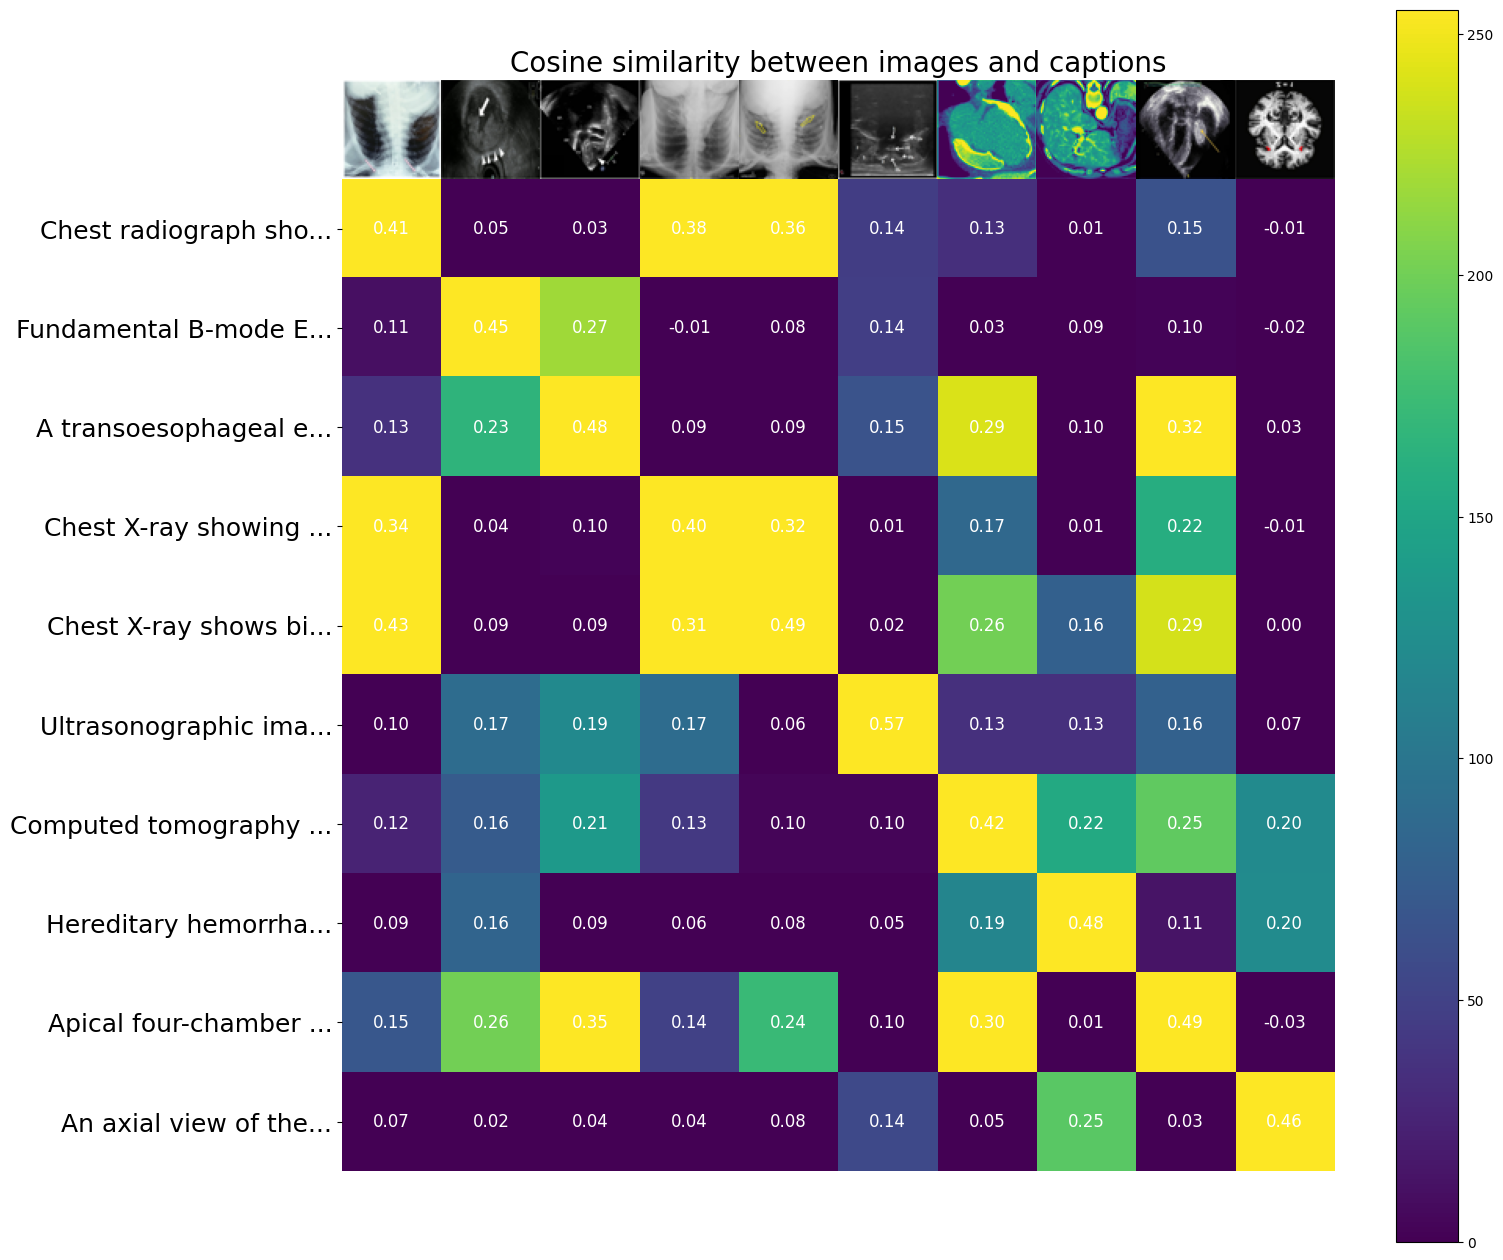

In [8]:
def load_images_from_folder(folder_path, image_labels, size=(64, 64)):
    images = []
    for label in image_labels:
        img_path = os.path.join(folder_path, label)
        if os.path.exists(img_path):
            img = Image.open(img_path).resize(size)  # Resize image for better display
            images.append(img)
    return images

def shorten_labels(labels, max_length=20):
    return [label if len(label) <= max_length else label[:max_length] + '...' for label in labels]

def plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, image_folder, title="Cosine similarity between images and captions"):
    # Shorten captions
    shortened_captions = shorten_labels(caption_labels)

    # Load images
    images = load_images_from_folder(image_folder, image_labels, size=(64, 64))

    count = len(shortened_captions)
    
    plt.figure(figsize=(16, 16))  # Adjust figsize to ensure each cell is large enough
    plt.imshow(cosine_sim_matrix, cmap='viridis', vmin=0.1, vmax=0.3)
    
    # Display images at the bottom
    for i, img in enumerate(images):
        plt.imshow(img, extent=(i - 0.5, i + 0.5, -0.5, -1.5), origin="lower")  # Adjust extent to position images properly
    
    # Display text annotations
    for x in range(cosine_sim_matrix.shape[1]):
        for y in range(cosine_sim_matrix.shape[0]):
            plt.text(x, y, f"{cosine_sim_matrix[y, x]:.2f}", ha="center", va="center", size=12, color='white')
    
    # Customize axes
    plt.yticks(range(count), shortened_captions, fontsize=18)
    plt.xticks([])
    
    # Hide spines
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)
    
    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count - 0.5, -1.5])  # Adjust limits to fit the images and text
    
    plt.title(title, size=20)
    plt.colorbar()  # Optional: Display colorbar if needed

    plt.show()


plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, test_image_folder)

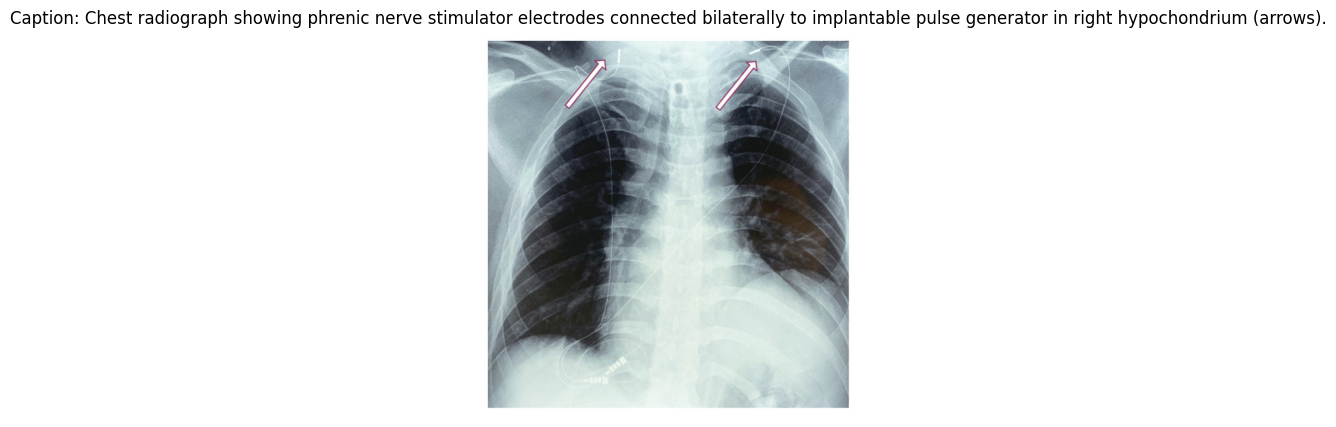

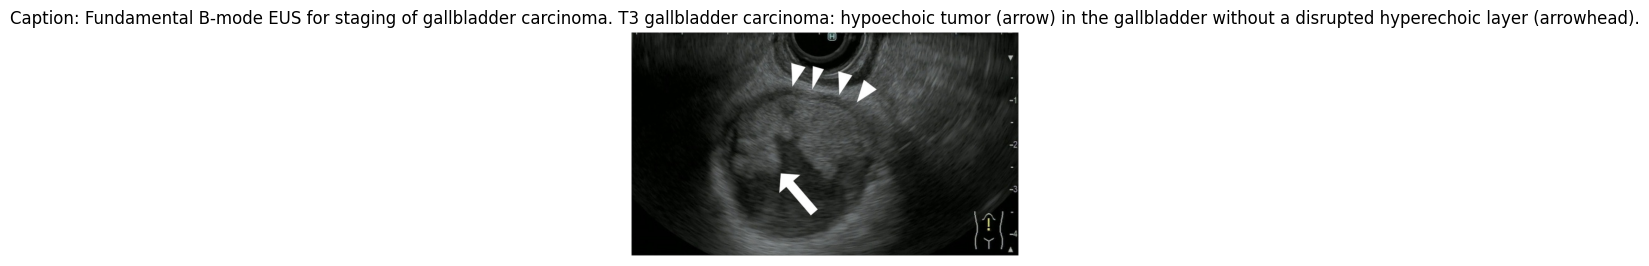

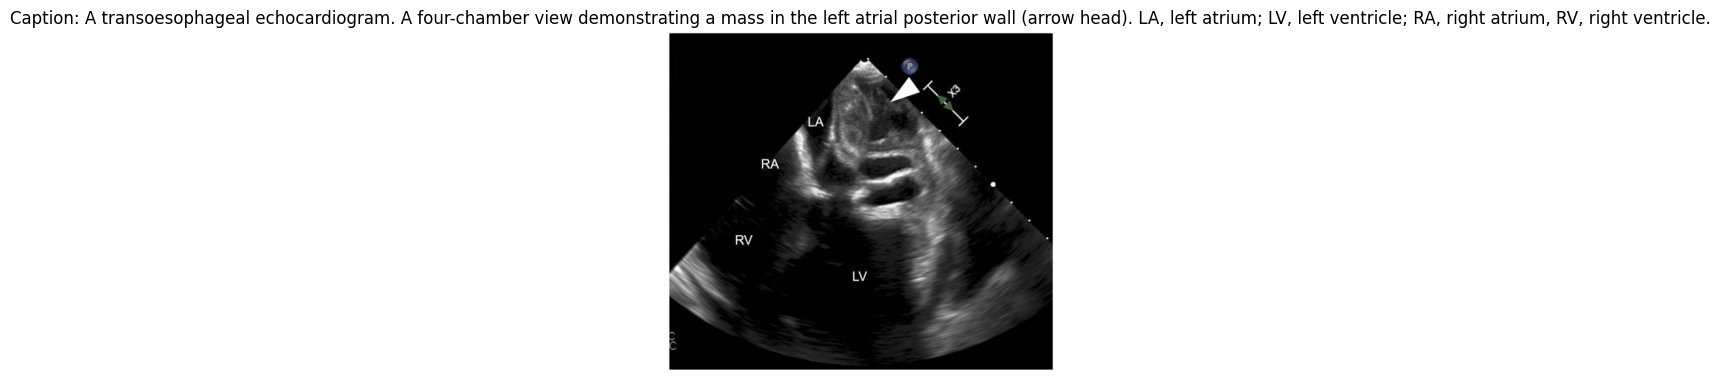

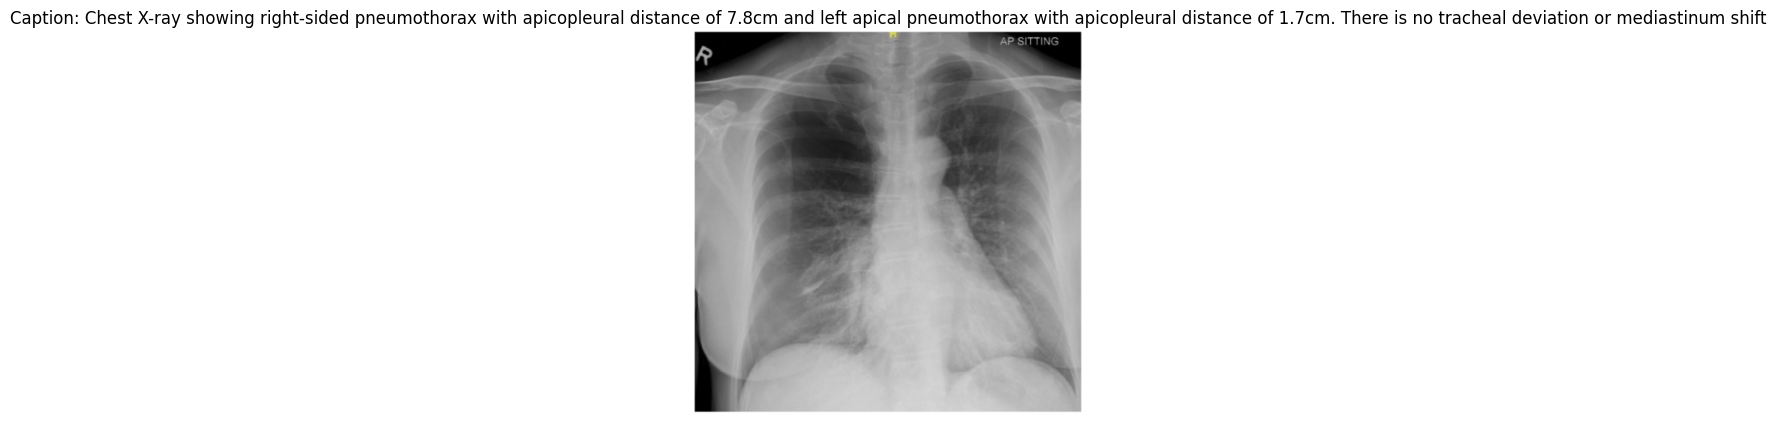

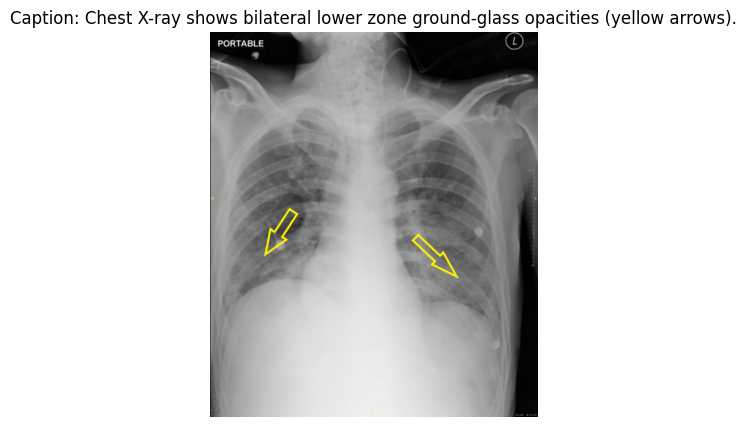

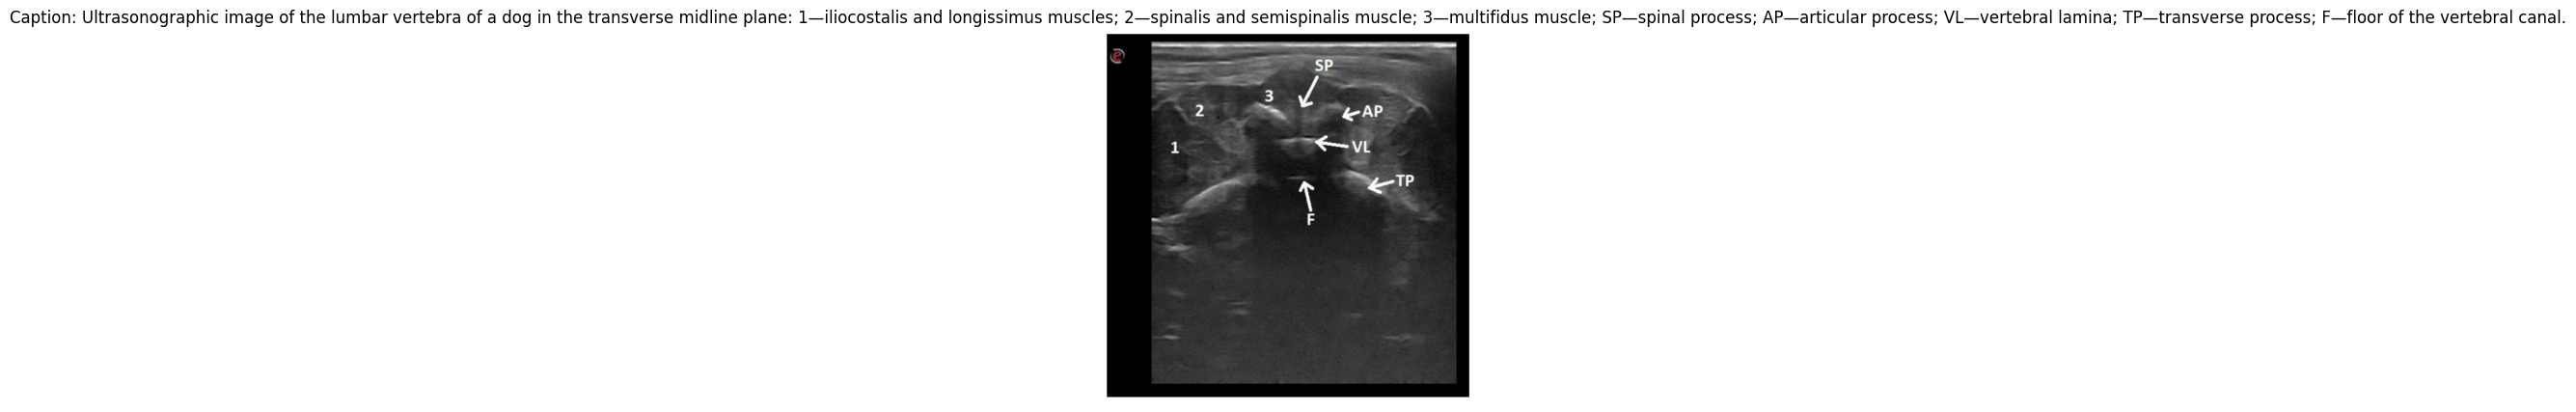

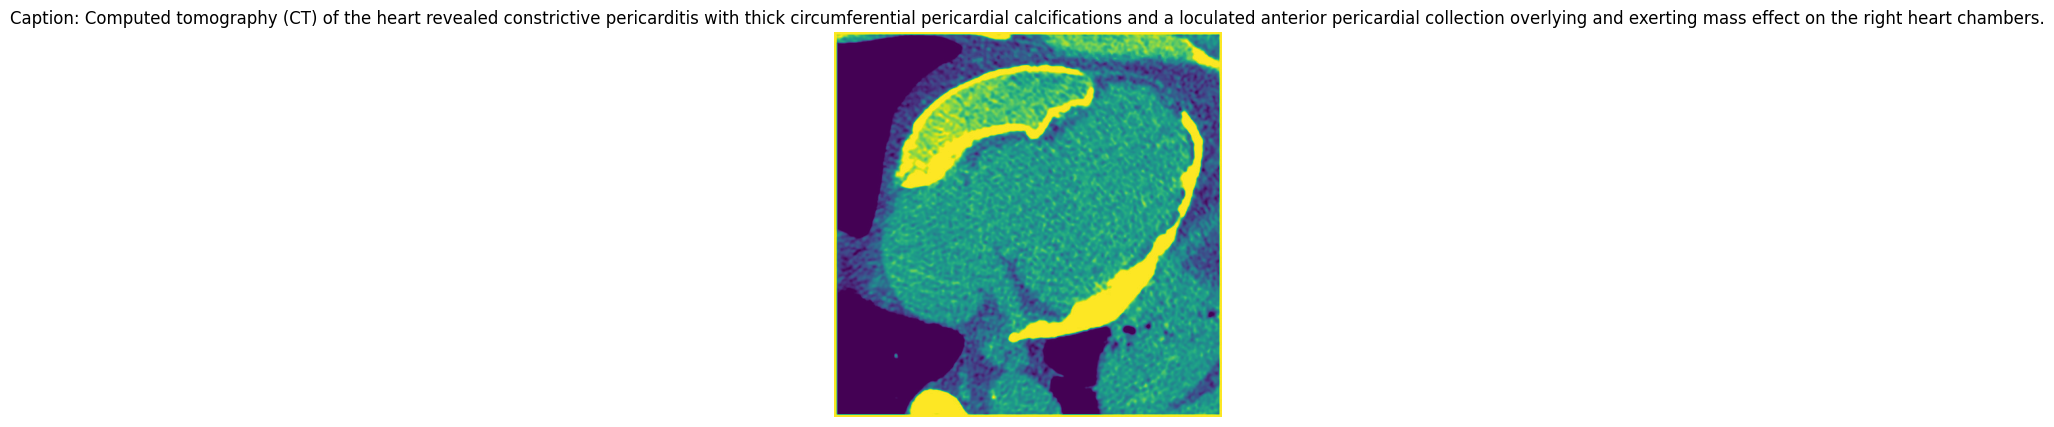

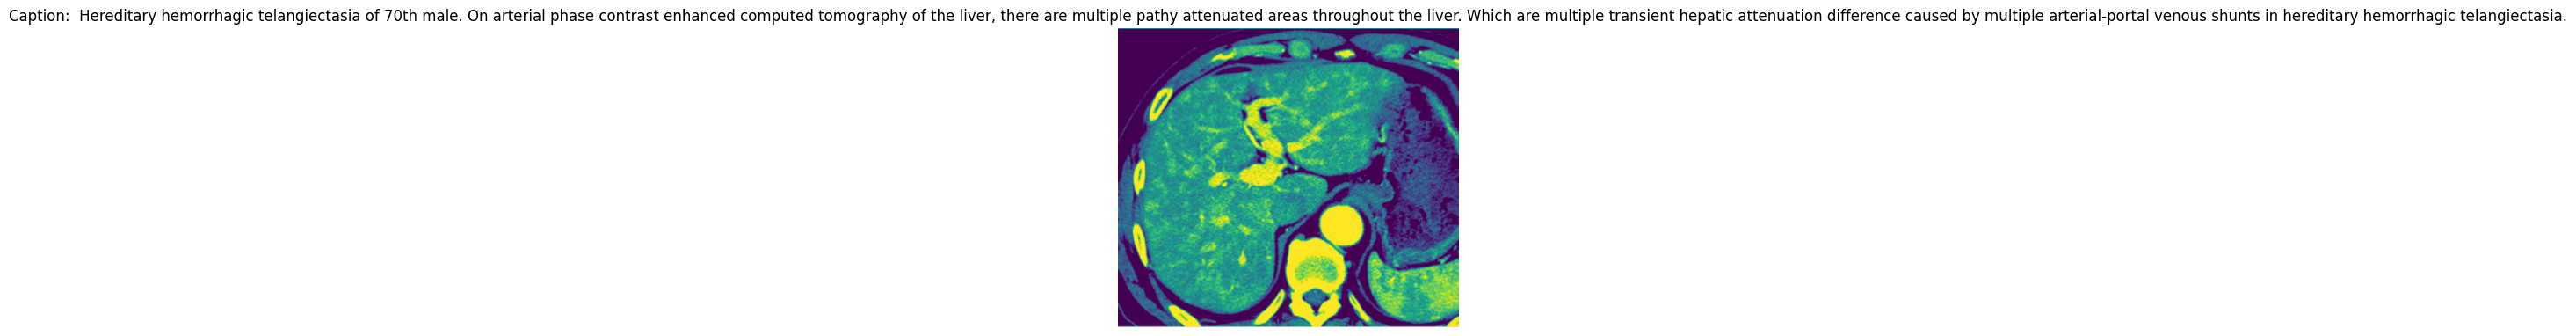

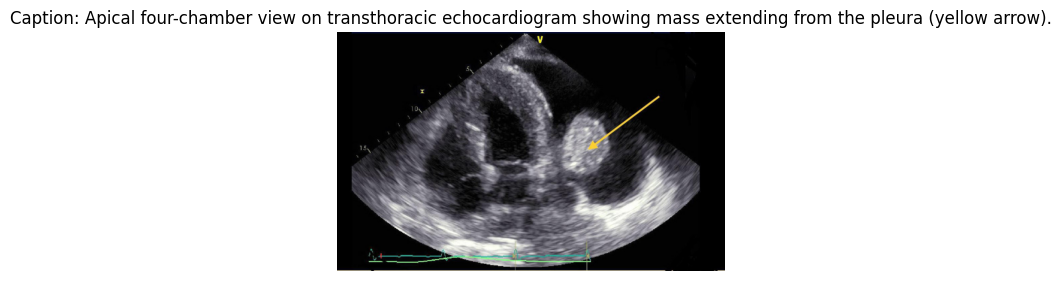

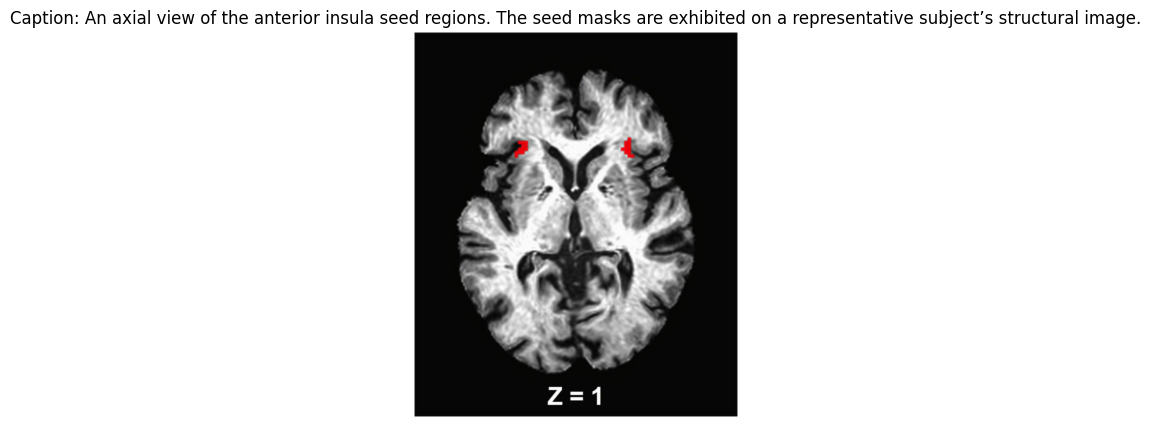

In [9]:
# Print the Image + the caption underneath for each 10 samples using seaborn
for i in range(num_samples):
    img_path = os.path.join(test_image_folder, test_df_subset.loc[i, 'Image'])
    img = Image.open(img_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Caption: {test_df_subset.loc[i, 'Caption']}", fontsize=12)
    plt.axis('off')
    plt.show()

Testing 10 Samples from papers

In [13]:
# Load data
sample_caption_file = "../Datasets/Paper Samples/Samples/Samples.csv"
sample_image_folder = "../Datasets/Paper Samples/Samples/Images"
sample_df = pd.read_csv(sample_caption_file , sep=',', header=0, names=['Caption','Image','Paper/Article','Figure No.','PMID'])

sample_df

Caption         Image  \
0  Radiograph of wrist showing ABC of the distal ...   sample1.jpg   
1  Ear scapha squamous cell carcinoma. Patient ph...   sample2.jpg   
2  A 49-year-old female COVID-19 patient presenti...   sample3.jpg   
3  63-year-old woman with advanced adenocarcinoma...   sample4.jpg   
4  Patient 16. Pre- and post-treatment images in ...   sample5.jpg   
5  Hip joint MRI of a patient with first-time fem...   sample6.jpg   
6  Histology of orthotopic colon tumors. (A) One ...   sample7.jpg   
7  Unoperated “congenitally corrected” transposit...   sample8.jpg   
8  A man in his 60s with gastric cancer (well-dif...   sample9.jpg   
9  An 8-year-old boy on steroids with cough and n...  sample10.jpg   

                                       Paper/Article  \
0     Bone cysts Unicameral and aneurysmal bone cyst   
1  Skin cancer: findings and role of high-resolut...   
2  Chest CT manifestations of new coronavirus dis...   
3  Imaging of Precision Therapy for Lung Cancer: ...   
4     Diffusion imaging in obstructive hydrocephalus   
5  Femoral neck fracture after femoral head necro...   
6  Magnetic Resonance Imaging and Bioluminescence...   
7         Imaging congenital heart disease in adults   
8  Characteristics and Early Diagnosis of Gastric...   
9  Tuberculosis revisted: classic imaging finding...   

                                          Figure No.      PMID  
0                                Fig. 6.  Section a.  25579825  
1                                            Fig. 4.  31069756  
2                                           Fig. 6.   32193638  
3                                           Fig. 2a.  31385753  
4                                         Fig. 4. A.  12812949  
5  Fig. 3. Every section, want to test for multip...  37907913  
6                         Fig. 5. All sections again  30988343  
7                                         Fig. 4. a.  22723533  
8                                         Fig. 2. D.  32321202  
9                                            Fig. 1   37217783

In [14]:
# Load and preprocess images
images = torch.stack([
    preprocess_val(Image.open(os.path.join(sample_image_folder, img))) 
    for img in sample_df['Image']
]).to(device)

# Tokenize captions
captions = tokenizer([caption for caption in sample_df['Caption']], context_length=context_length).to(device)

In [15]:
with torch.no_grad():
    image_features, caption_features, logits= model(images, captions)

In [16]:
# Move tensors to CPU and convert to numpy arrays
image_features_np = image_features.cpu().numpy()
caption_features_np = caption_features.cpu().numpy()

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(image_features_np, caption_features_np)

# Prepare labels
image_labels = sample_df['Image'].tolist()
caption_labels = sample_df['Caption'].tolist()

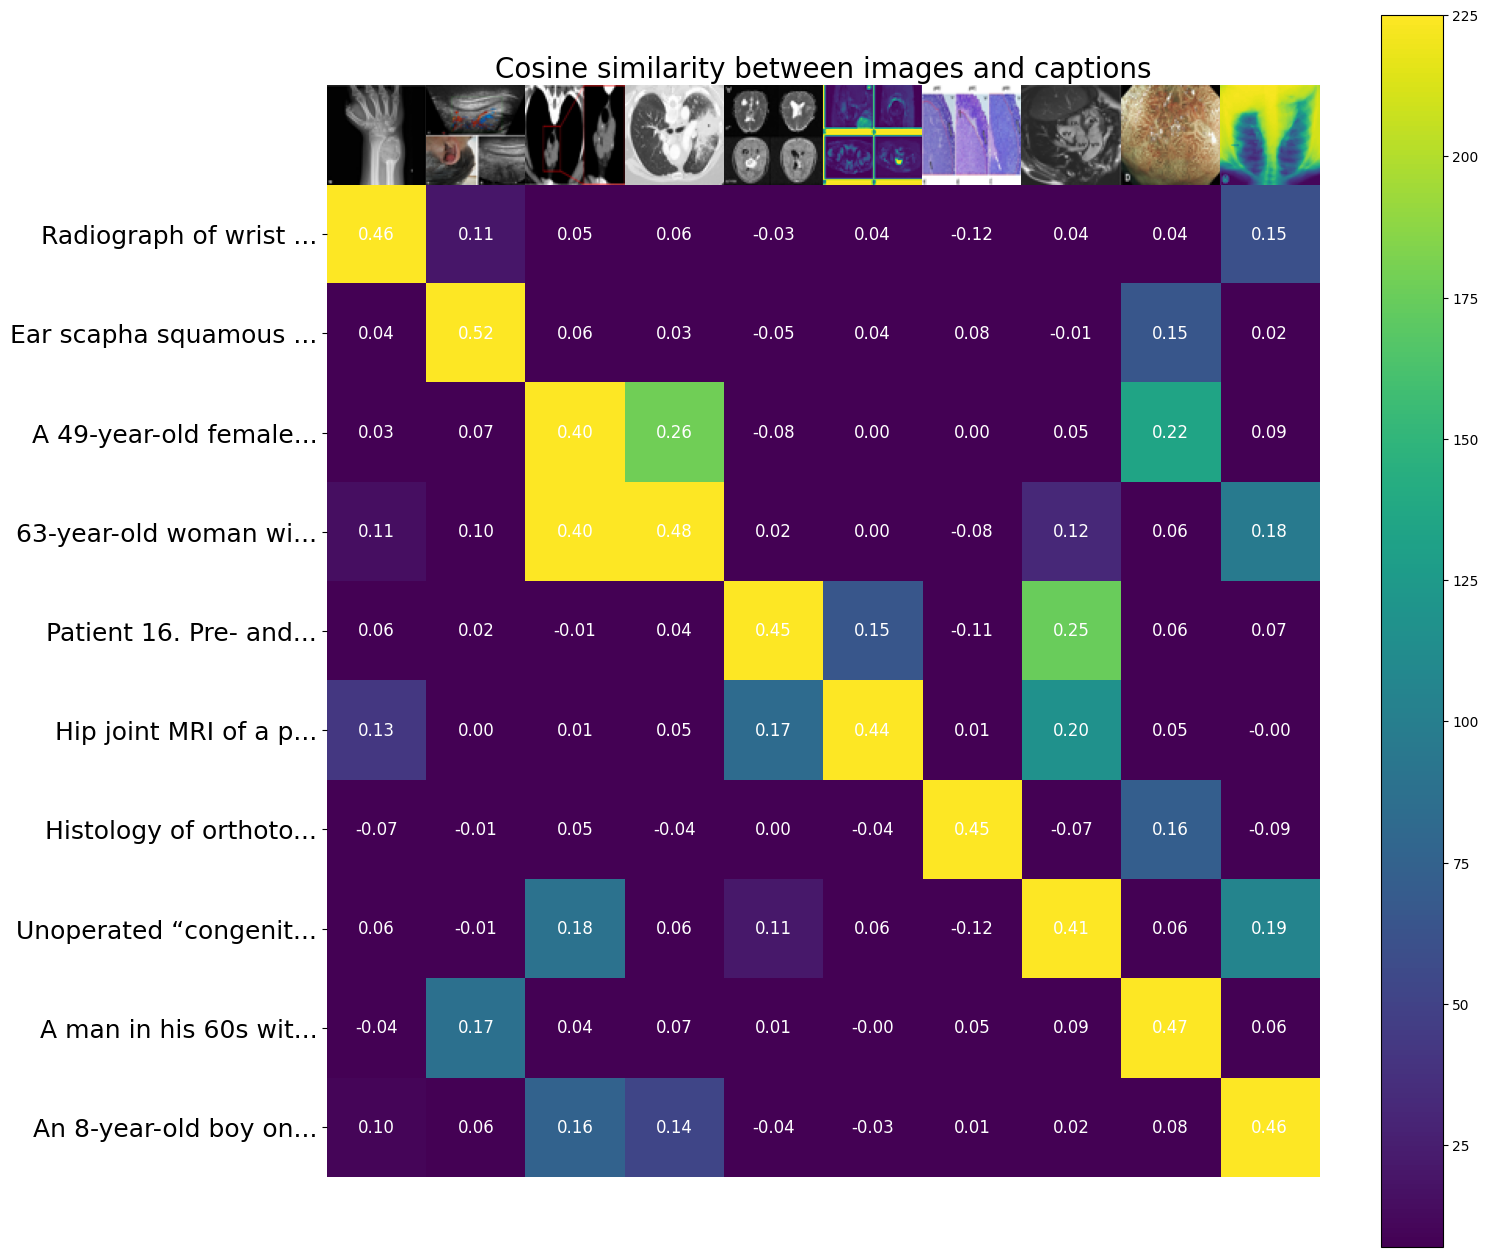

In [17]:
plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, sample_image_folder)

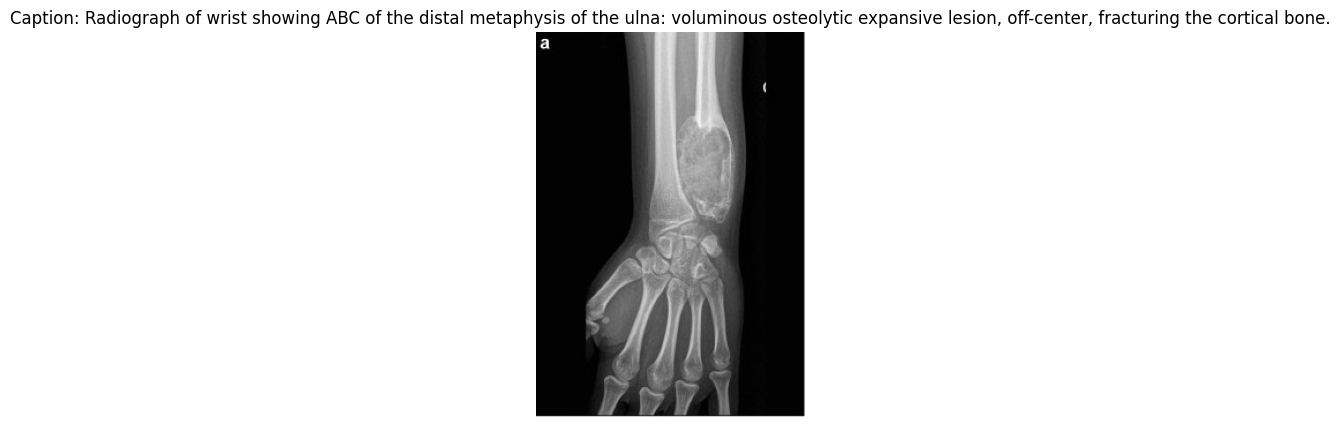

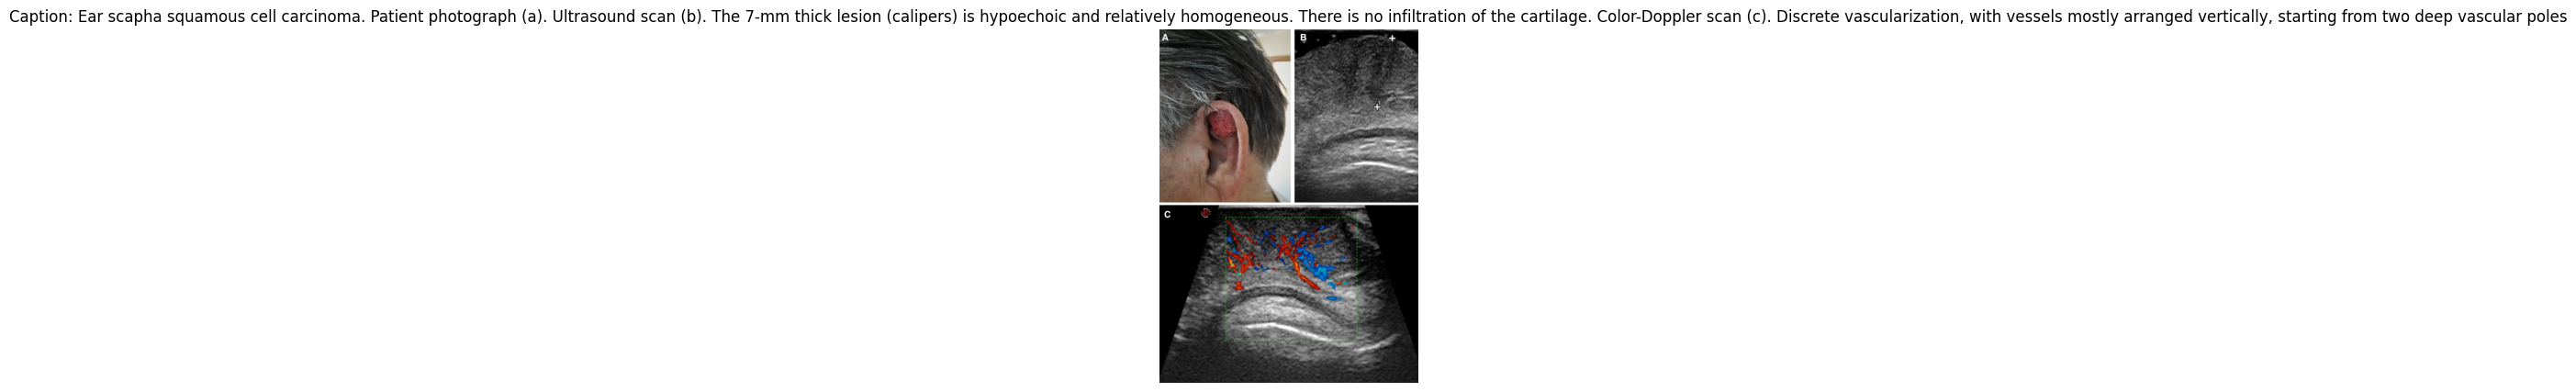

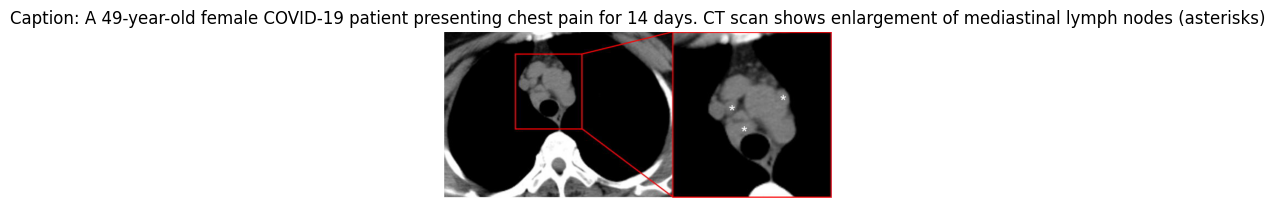

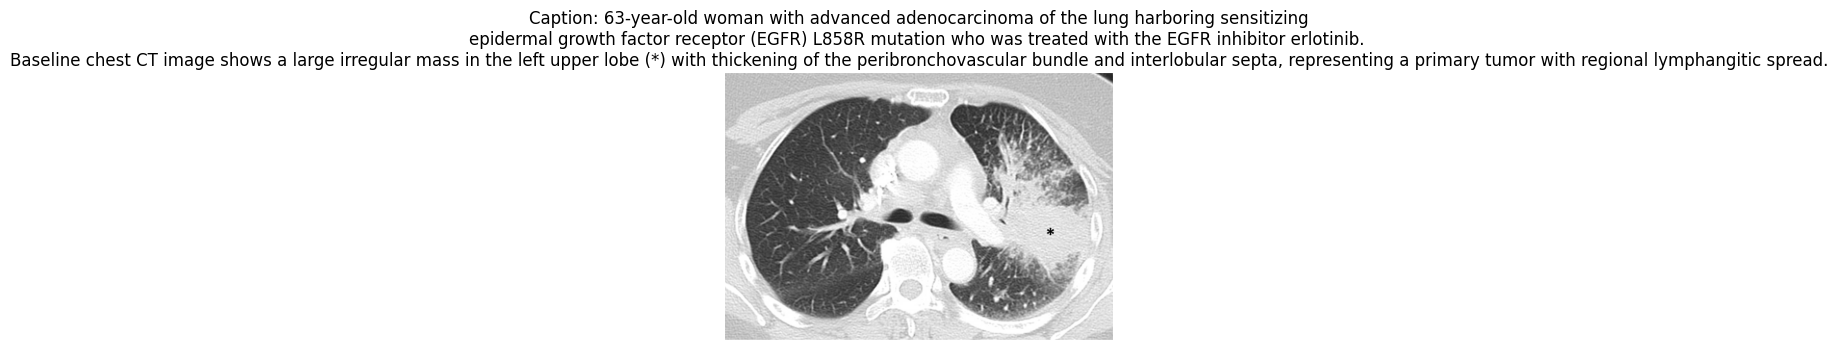

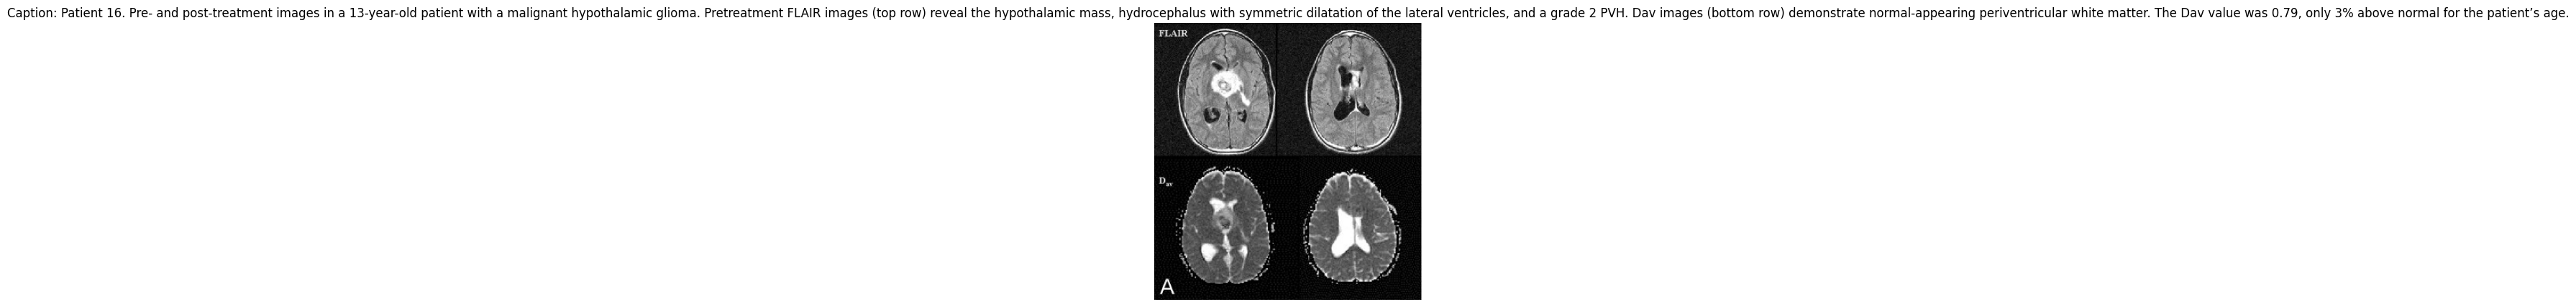

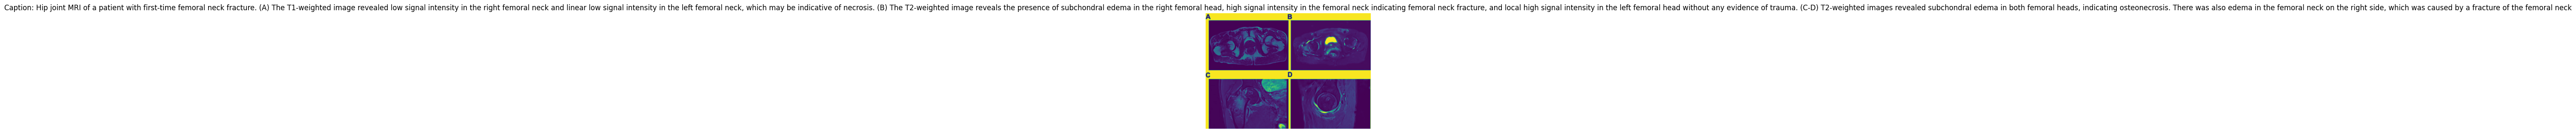

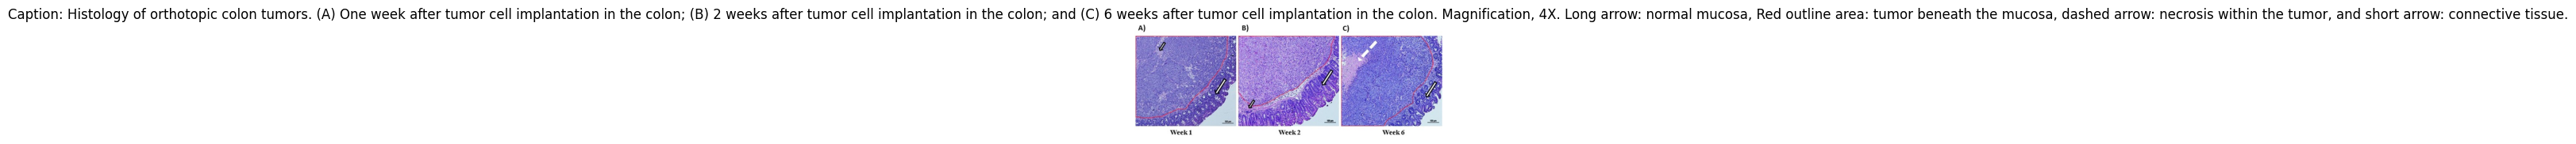

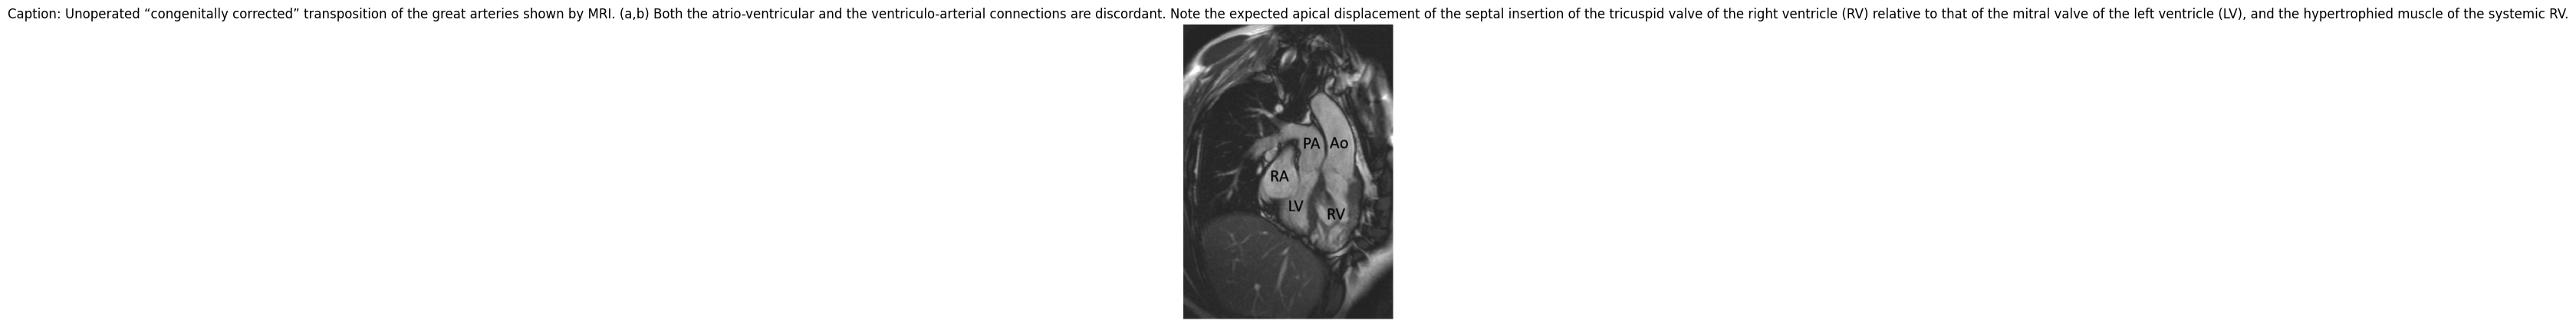

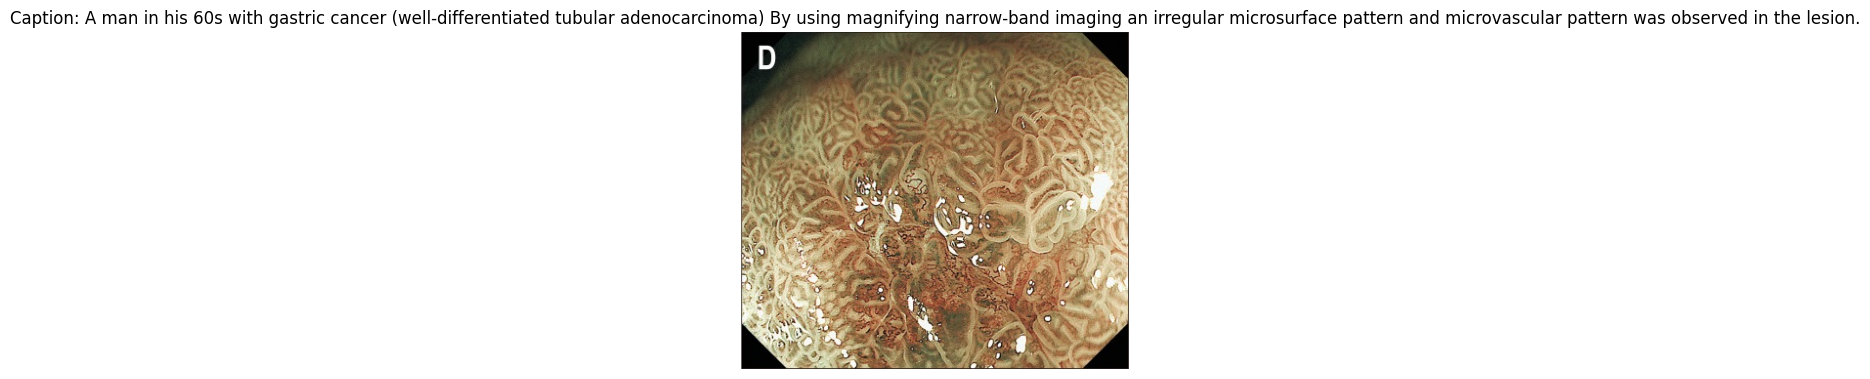

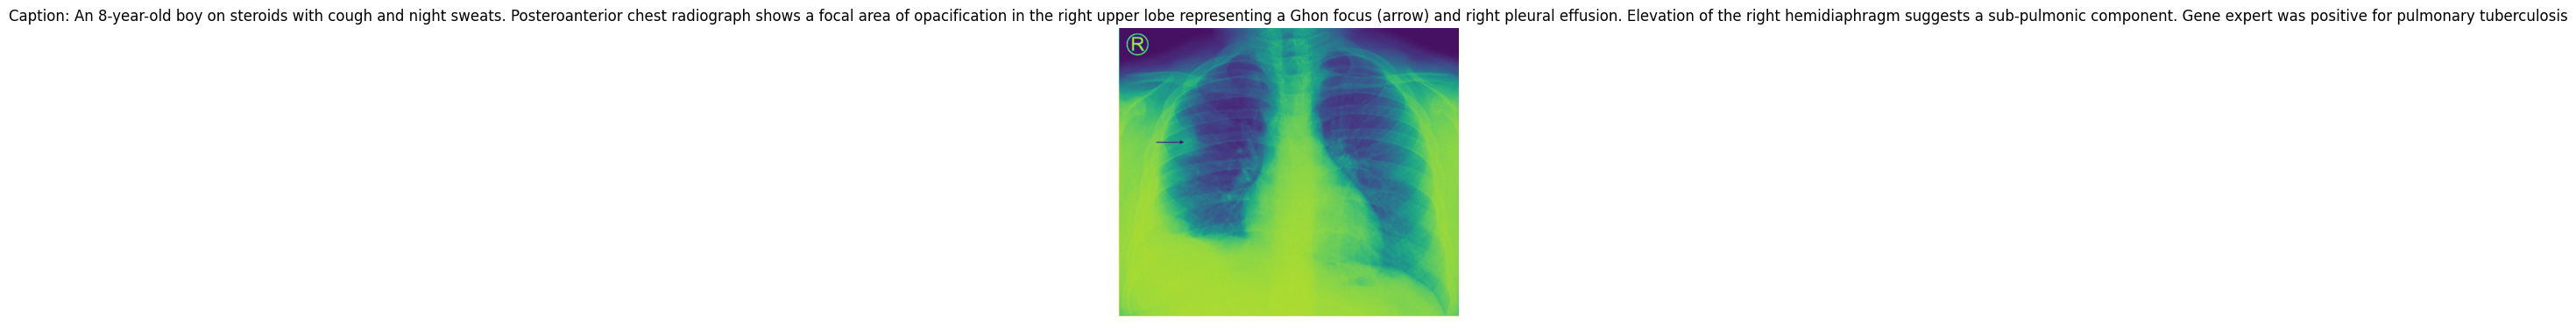

In [18]:
# Print the Image + the caption underneath for each 10 samples using seaborn
for i in range(num_samples):
    img_path = os.path.join(sample_image_folder, sample_df.loc[i, 'Image'])
    img = Image.open(img_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Caption: { sample_df.loc[i, 'Caption']}", fontsize=12)
    plt.axis('off')
    plt.show()